## `Detect and Count the Hazardous Substance in Metal Scrap`

### YOLOv9s 

In [ ]:
# Check GPU Status in Google Colob or Local Machine
!nvidia-smi  # For GPU

Wed May  7 17:03:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Check if GPU is available with pytorch
import torch
print(torch.cuda.is_available()) # True if GPU is avilable

True


# **Monting google drive**

In [ ]:
from google.colab import drive  # for mounting google drive if needed
drive.mount('/content/drive')

Mounted at /content/drive


# **Installation and Importing Libraries**

In [ ]:

# Install necessary libraries for YOLOv9 and COCO dataset handling
!pip install ultralytics
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

# **Data Conversion**

In [ ]:
import os # Provides functions for interacting with the operating system
import json # used to read and parse JSON files
from pathlib import Path # for handling and manipulating file paths

def coco_to_yolo_bbox(coco_json_path, images_dir, output_labels_dir):
    """
    Convert COCO format annotations (in JSON) to YOLOv9 bounding box format.

    Args:
        coco_json_path (str): Path to the input COCO JSON annotation file.
        images_dir (str): Path to the directory containing images (not used here directly).
        output_labels_dir (str): Path where YOLO-format label .txt files will be saved.
    """
    # Load the COCO JSON file
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # create a mapping from coco category ids to yolo class indices
    category_mapping = {category['id']: idx for idx, category in enumerate(coco_data['categories'])}

    # Create output directory if it doesn't exist
    os.makedirs(output_labels_dir, exist_ok=True)

    # iterate through each image entry in the coco dataset
    for image in coco_data['images']:
        image_id = image['id'] # unique image id
        image_filename = image['file_name'] # image file name
        img_width, img_height = image['width'], image['height'] # image width and height

        # create the output path for the label file
        label_path = os.path.join(output_labels_dir, f"{Path(image_filename).stem}.txt")

        # Open label file for writing
        with open(label_path, 'w') as label_file:
            # Get annotations for this image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

            # Process each annotation(bounding box for the image)
            for ann in annotations:
                category_id = ann['category_id'] # Coco category id
                class_idx = category_mapping[category_id] # yolo class index

                # Extract and normalize bounding box
                x, y, w, h = ann['bbox']
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height

                # Clip values to [0, 1] range
                x_center = min(max(x_center, 0), 1)
                y_center = min(max(y_center, 0), 1)
                w_norm = min(max(w_norm, 0), 1)
                h_norm = min(max(h_norm, 0), 1)

                # Write YOLO bbox line
                label_file.write(f"{class_idx} {x_center} {y_center} {w_norm} {h_norm}\n")

    print(f"[INFO] Converted annotations from: {coco_json_path} ➝ {output_labels_dir}")


In [ ]:
# === Step 1: Convert COCO to YOLOv9 Bounding Box Format for All Splits ===
# Define the base directory where original COCO-format dataset is stored
base_dir = '/content/drive/MyDrive/project_265/Dataset'

# Define the base output directory where YOLO-formatted labels will be saved
output_base_dir = '/content/drive/MyDrive/project_265/Yolo_conversion'
splits = ['train', 'val', 'test']

# Loop through each dataset split
for split in splits:
    # path to coco json annotation file for this split
    coco_json_path = f"{base_dir}/{split}/{split}.json"
    images_dir = f"{base_dir}/{split}/images" # path to image directory for the split
    # Path where YOLO-format label .txt files should be saved
    output_labels_dir = f"{output_base_dir}/{split}/labels"

    # Call the conversion function to convert COCO to YOLOv9 format
    coco_to_yolo_bbox(coco_json_path, images_dir, output_labels_dir)

print("[INFO] All COCO annotations converted to YOLOv8 bounding box format.")


[INFO] Converted annotations from: /content/drive/MyDrive/project_265/Dataset/train/train.json ➝ /content/drive/MyDrive/project_265/Yolo_conversion/train/labels
[INFO] Converted annotations from: /content/drive/MyDrive/project_265/Dataset/val/val.json ➝ /content/drive/MyDrive/project_265/Yolo_conversion/val/labels
[INFO] Converted annotations from: /content/drive/MyDrive/project_265/Dataset/test/test.json ➝ /content/drive/MyDrive/project_265/Yolo_conversion/test/labels
[INFO] All COCO annotations converted to YOLOv8 bounding box format.


# **YAML file creation**

In [ ]:
# === Step 2: Create dataset.yaml File Automatically ===
# Prompt the user to enter the full path to the COCO annotation JSON file (usually train.json)
coco_json_path = input("\nEnter the full path of your COCO JSON file (e.g., train_annotations.json): ")

# Prompt the user to enter the base output directory for the converted YOLO dataset
output_base_dir = input("Enter the base output directory for the converted dataset (e.g., '/content/drive/MyDrive/Yolo_conversions/'): ")

# Load JSON and extract class information
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Extract the list of classes names from the 'categories' field in the json
class_names = [cat['name'] for cat in coco_data['categories']]

# Build a dictionary in the format expected by YOLOv8 for dataset.yam
dataset_yaml = {
    'train': os.path.join(output_base_dir, 'train/images'), # path for training images
    'val': os.path.join(output_base_dir, 'val/images'),     # path for validation images
    'test': os.path.join(output_base_dir, 'test/images'),   # path for test images
    'nc': len(class_names),                                 # number of classes
    'names': class_names                                    # list of classes
}

# define the ful path where dataset.yanl will be saved
yaml_output_path = os.path.join(output_base_dir, 'dataset.yaml')

# write the dataset.yaml dictionary to a yaml file
with open(yaml_output_path, 'w') as yaml_file:
    yaml.dump(dataset_yaml, yaml_file)

# notify the user that the yaml file was successfully created
print(f"[INFO] dataset.yaml created at: {yaml_output_path}")


Enter the full path of your COCO JSON file (e.g., train_annotations.json): /content/drive/MyDrive/project_265/Dataset/train/train.json
Enter the base output directory for the converted dataset (e.g., '/content/drive/MyDrive/Yolo_conversions/'): /content/drive/MyDrive/project_265/Yolo_conversion
[INFO] dataset.yaml created at: /content/drive/MyDrive/project_265/Yolo_conversion/dataset.yaml


## **Model Building**

In [ ]:
from ultralytics import YOLO

# Step 1: Load the pre-trained YOLOv9 model (small version in this case)
model = YOLO('yolov9s.pt')  # You can switch to yolov9s.pt, yolov9l.pt, or yolov9x.pt for resources

# Step 2: Train the YOLOv9 model
results = model.train(
    data="/content/drive/MyDrive/project_265/Yolo_conversion/dataset.yaml",  # Path to dataset YAML file
    epochs=30,            # Number of epochs
    imgsz=640,            # Image size for training (640x640)
    batch=8,              # Batch size (adjust based on GPU memory)
    lr0=0.001,            # Initial learning rate
    workers=2,            # Number of data loader workers (parallel loading)
    optimizer="AdamW",    # Optimizer (AdamW is a good choice for many cases)
    patience=5,           # Early stopping if no improvement for 5 epochs
    device=0              # Device to use (0 for GPU, 'cpu' for CPU)
)

# Step 3: Output the results
print(f"Training completed! Model results: {results}")


Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/project_265/Yolo_conversion/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=5, perspective=0.0, p

train: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265_yolov8/Yolo_conversion/train/labels.cache... 2236 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2236/2236 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.2±2.6 ms, read: 23.9±8.0 MB/s, size: 96.6 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265_yolov8/Yolo_conversion/val/labels.cache... 639 images, 0 backgrounds, 0 corrupt: 100%|██████████| 639/639 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       4.6G      1.329      2.563      1.608         38        640: 100%|██████████| 280/280 [01:52<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:15<00:00,  2.62it/s]

                   all        639       2306      0.395      0.416      0.306      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.66G      1.249      2.058       1.57         27        640: 100%|██████████| 280/280 [01:45<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]

                   all        639       2306      0.506      0.418      0.405      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.66G      1.239      1.862      1.543         21        640: 100%|██████████| 280/280 [01:50<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.69it/s]

                   all        639       2306      0.509      0.558      0.497       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.66G      1.146      1.717      1.489         47        640: 100%|██████████| 280/280 [01:47<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.74it/s]

                   all        639       2306      0.539      0.626      0.616      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.66G      1.098      1.567      1.451         18        640: 100%|██████████| 280/280 [01:43<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:15<00:00,  2.53it/s]


                   all        639       2306      0.576      0.636      0.645      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.66G      1.037       1.44      1.393         26        640: 100%|██████████| 280/280 [01:47<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]

                   all        639       2306      0.704      0.712      0.766      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.66G     0.9794      1.287      1.355         26        640: 100%|██████████| 280/280 [01:42<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]

                   all        639       2306      0.655      0.722      0.766      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.66G     0.9355      1.166       1.32         39        640: 100%|██████████| 280/280 [01:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.59it/s]

                   all        639       2306      0.747      0.734      0.811      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.66G     0.9009      1.091      1.291         13        640: 100%|██████████| 280/280 [01:42<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.78it/s]

                   all        639       2306      0.826      0.781      0.866      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.66G     0.8667     0.9962      1.257         39        640: 100%|██████████| 280/280 [01:36<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.20it/s]

                   all        639       2306      0.826      0.812      0.898      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.66G     0.8336     0.9412      1.238         30        640: 100%|██████████| 280/280 [01:42<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]

                   all        639       2306      0.851      0.863      0.923      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.66G      0.799     0.8823      1.209         44        640: 100%|██████████| 280/280 [01:44<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]

                   all        639       2306      0.871      0.859      0.935       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.66G     0.7769     0.8603      1.197         15        640: 100%|██████████| 280/280 [01:41<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:15<00:00,  2.57it/s]

                   all        639       2306      0.881      0.858      0.935      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.66G      0.741     0.7802      1.172         35        640: 100%|██████████| 280/280 [01:40<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.29it/s]

                   all        639       2306      0.901      0.884      0.947      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.66G     0.7215     0.7525      1.155         34        640: 100%|██████████| 280/280 [01:48<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.31it/s]

                   all        639       2306      0.917        0.9      0.964      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.66G     0.7211     0.7347      1.148         38        640: 100%|██████████| 280/280 [01:39<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.38it/s]

                   all        639       2306      0.934      0.894      0.962      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.66G     0.6842     0.6692      1.129         17        640: 100%|██████████| 280/280 [01:39<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]

                   all        639       2306      0.929      0.909      0.968       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.66G     0.6646     0.6373      1.115         38        640: 100%|██████████| 280/280 [01:45<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:15<00:00,  2.55it/s]

                   all        639       2306      0.923      0.914       0.97      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.66G     0.6615     0.6333      1.117         23        640: 100%|██████████| 280/280 [01:50<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.36it/s]

                   all        639       2306      0.946      0.935      0.976       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.66G     0.6245     0.5852      1.089         43        640: 100%|██████████| 280/280 [01:50<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:19<00:00,  2.02it/s]

                   all        639       2306      0.948      0.939      0.978      0.883


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.66G     0.5155     0.4714      1.016         15        640: 100%|██████████| 280/280 [01:37<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.45it/s]

                   all        639       2306      0.955      0.936      0.979      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.66G     0.4919     0.4189     0.9949         16        640: 100%|██████████| 280/280 [01:37<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.64it/s]

                   all        639       2306      0.948      0.944      0.983      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.66G     0.4674     0.3762      0.981          9        640: 100%|██████████| 280/280 [01:36<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.19it/s]

                   all        639       2306       0.96      0.948      0.986      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.66G     0.4449     0.3566       0.96          7        640: 100%|██████████| 280/280 [01:39<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.24it/s]

                   all        639       2306      0.969      0.946      0.986      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.66G      0.431     0.3413     0.9504         13        640: 100%|██████████| 280/280 [01:40<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.36it/s]

                   all        639       2306      0.961      0.959      0.987       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.66G     0.4132     0.3179     0.9375         21        640: 100%|██████████| 280/280 [01:35<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.40it/s]

                   all        639       2306      0.958      0.964      0.988      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.66G     0.3955     0.2946     0.9261         14        640: 100%|██████████| 280/280 [01:36<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]

                   all        639       2306      0.977      0.952      0.989       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.66G     0.3783     0.2785     0.9188         16        640: 100%|██████████| 280/280 [01:38<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


                   all        639       2306      0.967      0.962      0.989       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.66G     0.3733     0.2743     0.9133          7        640: 100%|██████████| 280/280 [01:38<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.43it/s]

                   all        639       2306      0.969      0.971       0.99      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.66G     0.3577     0.2603     0.9064         12        640: 100%|██████████| 280/280 [01:39<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:12<00:00,  3.32it/s]


                   all        639       2306      0.963      0.969       0.99      0.935

30 epochs completed in 0.979 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 15.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 197 layers, 7,170,571 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:14<00:00,  2.68it/s]


                   all        639       2306      0.963      0.971       0.99      0.935
          Gas Cylinder         58        267      0.983      0.993      0.995      0.957
      Fire Extingusher         73        321      0.955      0.956      0.982      0.897
Hydraulic/Pneaumatic cylinder        114        284      0.972      0.965      0.993      0.893
Aerosil cans/Paint tins         64        268       0.96      0.987      0.993      0.966
           Compressors         49        206      0.985      0.989      0.995      0.958
           Oil Filters         71        195       0.95      0.979      0.992      0.964
      Fuel tanks/ Cans        106        230       0.96      0.943      0.985      0.948
             Batteries         79        316      0.938      0.965      0.987      0.923
     Ammunition Shells         40        219      0.961      0.959      0.988      0.906
Speed: 0.4ms preprocess, 6.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to run

# **Validation Results**

In [ ]:
# === Step: Run Validation on the Trained Model ===
print("\n[INFO] Validating the model on validation dataset...")
val_results = model.val()

# === Step: Print Validation Results ===
print(f"\n[RESULT] Validation Results:")
print(f" - mAP@0.5:       {val_results.box.map50:.4f}") # mAP at IoU=0.5 for object detection boxes
print(f" - mAP@0.5:0.95:  {val_results.box.map:.4f}")   # mAP at IoU=0.5:0.95 for object detection boxes
print(f" - Precision:     {val_results.box.mp:.4f}")    # Precision of the model
print(f" - Recall:        {val_results.box.mr:.4f}")    # Recall of the model




[INFO] Validating the model on validation dataset...
Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 197 layers, 7,170,571 parameters, 0 gradients, 26.7 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 52.5±49.2 MB/s, size: 137.1 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265_yolov8/Yolo_conversion/val/labels.cache... 639 images, 0 backgrounds, 0 corrupt: 100%|██████████| 639/639 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 80/80 [00:18<00:00,  4.43it/s]


                   all        639       2306      0.963      0.969       0.99      0.935
          Gas Cylinder         58        267      0.983      0.993      0.995      0.958
      Fire Extingusher         73        321      0.956      0.956      0.982      0.897
Hydraulic/Pneaumatic cylinder        114        284      0.972      0.961      0.993      0.896
Aerosil cans/Paint tins         64        268       0.96      0.987      0.993      0.968
           Compressors         49        206      0.985      0.987      0.995      0.959
           Oil Filters         71        195       0.95      0.979      0.992      0.964
      Fuel tanks/ Cans        106        230      0.962      0.943      0.985      0.947
             Batteries         79        316      0.939      0.959      0.987      0.923
     Ammunition Shells         40        219      0.964      0.954      0.988      0.906
Speed: 0.5ms preprocess, 11.9ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to ru

# **Test Results**

In [ ]:
metrics = model.val(split='test')  # Use test images as defined in dataset.yaml
print(metrics) # Print the metrics for test dataset


Ultralytics 8.3.128 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 2.3±3.6 ms, read: 0.2±0.3 MB/s, size: 107.8 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265_yolov8/Yolo_conversion/test/labels... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [01:36<00:00,  3.32it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265_yolov8/Yolo_conversion/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]


                   all        320       1095      0.984      0.977      0.991      0.952
          Gas Cylinder         24        114      0.988          1      0.995      0.943
      Fire Extingusher         28        121      0.975      0.983      0.994      0.951
Hydraulic/Pneaumatic cylinder         50        110      0.982      0.968      0.984      0.905
Aerosil cans/Paint tins         25        113      0.973      0.971      0.994      0.975
           Compressors         24         93          1      0.952      0.994      0.956
           Oil Filters         62        205      0.976      0.996      0.994      0.977
      Fuel tanks/ Cans         59        128      0.983      0.969      0.992      0.961
             Batteries         28         99      0.995          1      0.995      0.957
     Ammunition Shells         25        112      0.981      0.955      0.978       0.94
Speed: 0.9ms preprocess, 10.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to ru

In [ ]:
print("\n[RESULT] Test Set Evaluation Metrics:") 
print(f" - mAP@0.5:       {metrics.box.map50:.4f}")
print(f" - mAP@0.5:0.95:  {metrics.box.map:.4f}")
print(f" - Precision:     {metrics.box.mp:.4f}")
print(f" - Recall:        {metrics.box.mr:.4f}")



[RESULT] Test Set Evaluation Metrics:
 - mAP@0.5:       0.9911
 - mAP@0.5:0.95:  0.9516
 - Precision:     0.9836
 - Recall:        0.9773


# **Accuracy and loss curves**

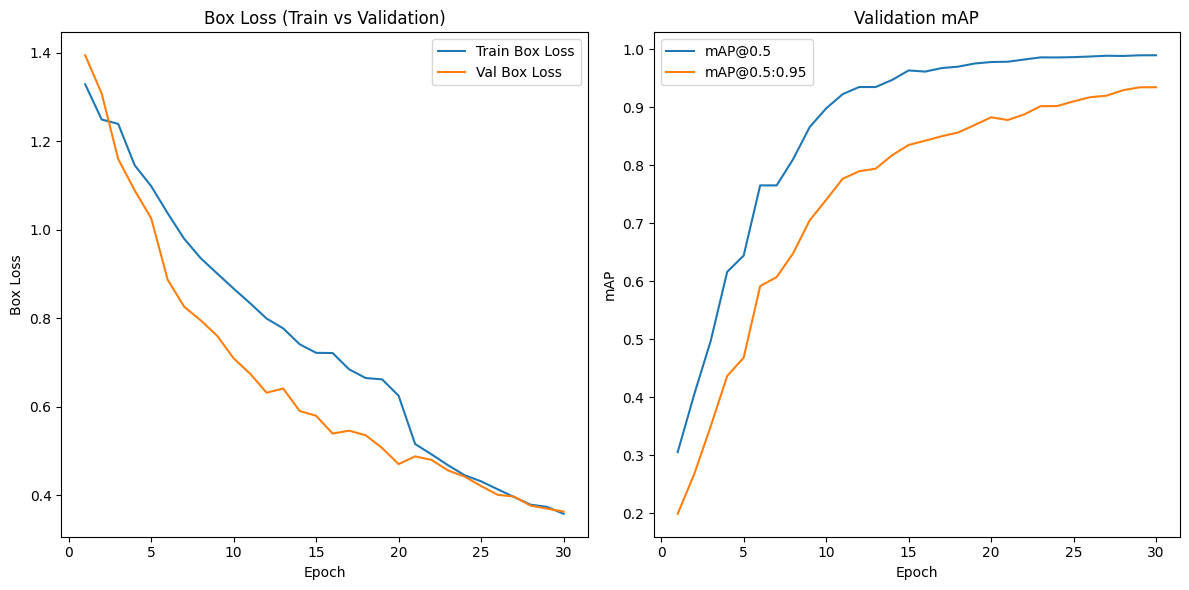

In [ ]:
plt.figure(figsize=(12, 6)) # Set the figure size for the plots

# Plot box loss
plt.subplot(1, 2, 1) # Adjust subplot layoutto fit the plots
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss') # Plot training box loss over epochs
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss')      # Plot validation box loss over epochs
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Box Loss (Train vs Validation)')
plt.legend()

# Plot mAP (adjust to correct column names)
plt.subplot(1, 2, 2)
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5')        # Plot mAP@0.5 over epochs
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95') # Plot mAP@0.5:0.95 over epochs
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP')
plt.legend()

plt.tight_layout()
plt.show()

# **Detect and Count on New Image**


image 1/1 /content/drive/MyDrive/project_265/Yolo_conversion/test/images/g20_aug_14.jpg: 480x640 10 Gas Cylinders, 39.8ms
Speed: 3.1ms preprocess, 39.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)
Detected Objects Count per Class:
Class 0: 10 objects


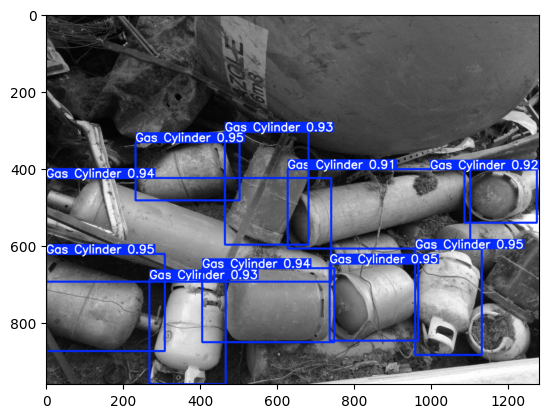


Detected Objects with Class Names:
Gas Cylinder: 10 objects


In [ ]:
from ultralytics import YOLO # Load the YOLOv9 model
import cv2 # OpenCV for image processing
import matplotlib.pyplot as plt # for displaying images

# Step 1: Load the trained YOLOv9 model (assuming you have a trained model)
# model = YOLO('/content/drive/MyDrive/yolov8_trained_model/best.pt')  # Path to your trained model

# Step 2: Make predictions on an image (single or batch)
image_path = '/content/drive/MyDrive/project_265/Yolo_conversion/test/images/g20_aug_14.jpg'  # Path to an image for inference
results = model.predict(image_path, conf = 0.20)  # Make predictions on the image

# Step 3: Count the number of objects for each class
detected_classes = results[0].boxes.cls.cpu().numpy()  # Extract class IDs from predictions

# Count the occurrences of each class
class_counts = {}
for cls in detected_classes:
    class_counts[int(cls)] = class_counts.get(int(cls), 0) + 1

# Print the count of objects per class
print("Detected Objects Count per Class:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} objects")

# Step 4: Optionally, show the image with bounding boxes and labels
# Visualize the results
plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
plt.show()
# Access the Results object from the list
results = results[0] # Get the Results object from the list

# Additional: You can use the class names from your dataset.yaml for better output
class_names = results.names  # If you want class names instead of IDs

print("\nDetected Objects with Class Names:")
for class_id, count in class_counts.items():
    print(f"{class_names[class_id]}: {count} objects")


# **Summary**

In [ ]:
print(f"Final Training Results Summary:")
print(f"📉 Final Train Box Loss: {results_df['train/box_loss'].iloc[-1]:.4f}") # trining box loss
print(f"📉 Final Val Box Loss: {results_df['val/box_loss'].iloc[-1]:.4f}") # validation box loss
print(f"✅ Final Val mAP@0.5: {results_df['metrics/mAP50(B)'].iloc[-1]:.4f}") #  validation mAP@0.5
print(f"✅ Final Val mAP@0.5:0.95: {results_df['metrics/mAP50-95(B)'].iloc[-1]:.4f}") # validation mAP@0.5:0.95

print("\n[INFO] For test set:")
print(f"✅ Test mAP@0.5: {metrics.box.map50:.4f}") # mAP@0.5 for test set
print(f"✅ Test mAP@0.5:0.95: {metrics.box.map:.4f}") # mAP@0.5:0.95 for test set
print(f"✅ Test Precision: {metrics.box.mp:.4f}") # Precision for test set
print(f"✅ Test Recall: {metrics.box.mr:.4f}") # Recall for test set


Final Training Results Summary:
📉 Final Train Box Loss: 0.3577
📉 Final Val Box Loss: 0.3626
✅ Final Val mAP@0.5: 0.9899
✅ Final Val mAP@0.5:0.95: 0.9348

[INFO] For test set:
✅ Test mAP@0.5: 0.9911
✅ Test mAP@0.5:0.95: 0.9516
✅ Test Precision: 0.9836
✅ Test Recall: 0.9773


# **Underfitting** Vs **Overfitting** 

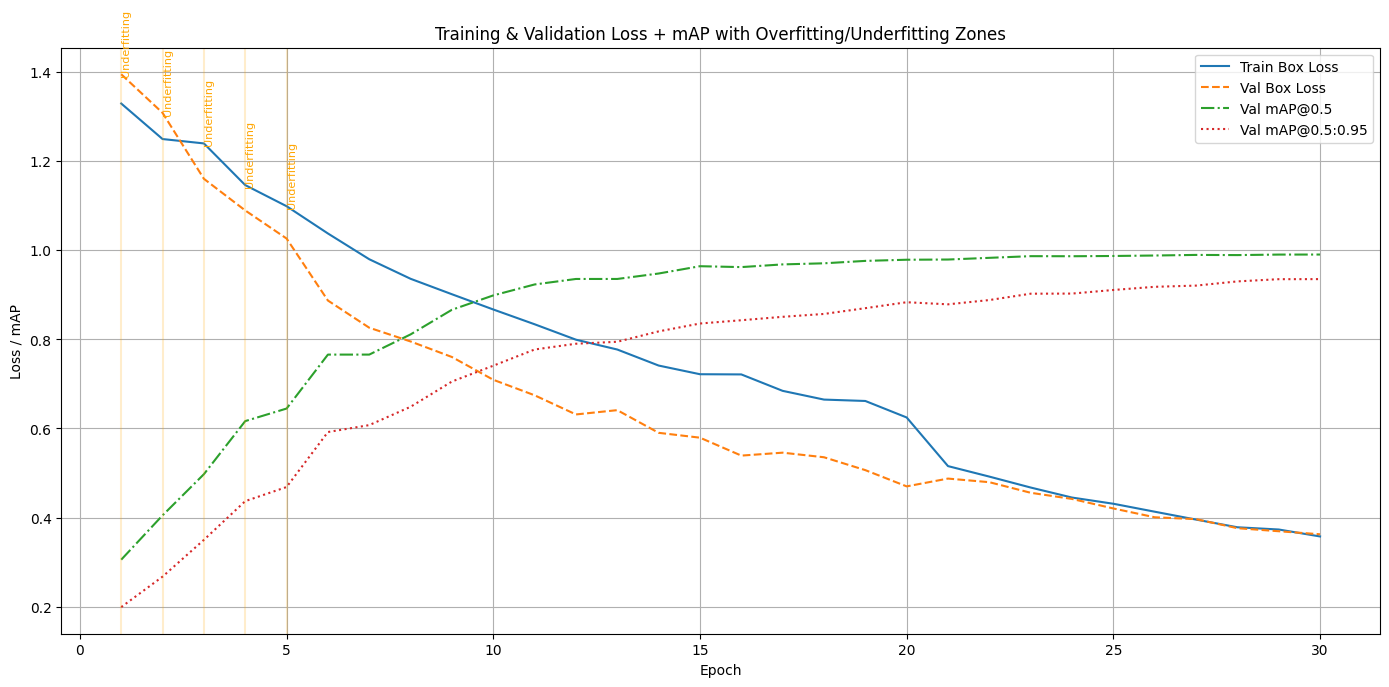

In [ ]:
import matplotlib.pyplot as plt # for plotting
import pandas as pd # for data manipulation

# Load training results
results_df = pd.read_csv('/content/runs/detect/train5/results.csv')


# Plotting
plt.figure(figsize=(14, 7))

# Plot losses and mAP
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss', linestyle='--')
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='Val mAP@0.5', linestyle='-.')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='Val mAP@0.5:0.95', linestyle=':')

# Annotate underfitting and overfitting zones
for epoch, train_loss, val_loss in zip(results_df['epoch'], results_df['train/box_loss'], results_df['val/box_loss']):
    if train_loss > 1.0 and val_loss > 1.0 and abs(train_loss - val_loss) < 0.1:
        plt.axvline(x=epoch, color='orange', alpha=0.2)
        plt.text(epoch, max(train_loss, val_loss), 'Underfitting', rotation=90, color='orange', fontsize=8)
    elif train_loss < 0.5 and val_loss > train_loss + 0.2:
        plt.axvline(x=epoch, color='red', alpha=0.2)
        plt.text(epoch, max(train_loss, val_loss), 'Overfitting', rotation=90, color='red', fontsize=8)

# Labels and formatting
plt.xlabel('Epoch')
plt.ylabel('Loss / mAP')
plt.title('Training & Validation Loss + mAP with Overfitting/Underfitting Zones')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
